In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import tensorflow as tf  # TF 1.x
import matplotlib.pyplot as plt

# Project root path
PROJECT_ROOT = os.path.abspath(os.path.join('..'))
sys.path.append(PROJECT_ROOT)

from modules.correlated_gaussians import CorrelatedGaussians
from modules.matrix_estimator import MatrixEstimator

%matplotlib inline

<h2>Effect of kernel width on estimated entropy of 2-dimensional variable</h2>

We show here the effect of the gaussian kernel width ($\sigma$) on the estimation. Note that we have the following properties for the estimator regarding $\sigma$ (proof is not shown here)

$$\lim_{\sigma\to 0} S(X) = \lim_{\sigma\to 0} I(X;Y) = \ln(N)$$
$$\lim_{\sigma\to \infty} S(X) = \lim_{\sigma\to \infty} I(X;Y) = 0$$

Where $N$ is the number of samples. We see that the estimator is bounded from below and from above. We say that the estimator is "saturated" if we reach the upper bound.

Since the estimator relies on the entropy of the discrete probability distribution defined by the $N$ eigenvalues of the normalized Gram matrix of $N\times N$ (obtained from the kernel evaluation on every pair of samples), we can interpret this result in the following way:

- If $\sigma$ is too small, the estimation converges to a maximum entropy case, which means that the values of the eigenvalues tend to be uniform. That is, each eigenvalue is equal to one another, and equal to a value of $1/N$.
- If $\sigma$ is too large, the estimation converges to a minimum entropy case, which means that the distribution tends to collapse to a "single bin". That is, a single eigenvalue has all the possible weight (equal to 1), while the rest has value of 0.

Additionally, we can interpret $\sigma$ as some sort of "bin size", if we were talking about histogram estimates.
- The larger the value of $\sigma$, the larger is the number of samples that end up in a bin, with the limiting case of all samples in one single bin (collapse). 
- The smaller the value of $\sigma$, the smaller is the number of samples that end up in a bin, with the limiting case of only one sample per bin, leaving every bin with equal size (uniformity).

We can expect that a proper tuning of $\sigma$ is needed to avoid both extremes and have meaningful estimates and comparisons between different variables. It can be proved that, without proper care, changes in variance or changes in the number of dimensions can increase or decrease the "effective" sigma, introducing artifacts.

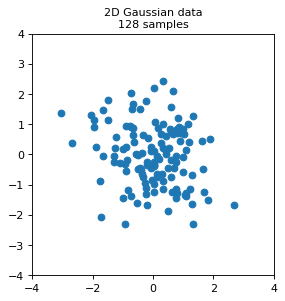

In [3]:
# Generate 2D data
n_samples = 128
z_samples = np.random.normal(size=(n_samples, 2)).astype(np.float32)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=80)
ax.scatter(z_samples[:, 0], z_samples[:, 1])
ax.axis('square')
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
ax.set_title('2D Gaussian data\n%d samples' % n_samples, fontsize=10)
plt.show()

In [4]:
print('Saturation value of estimator log(number of samples): %1.4f' % np.log2(n_samples))

Saturation value of estimator log(number of samples): 7.0000


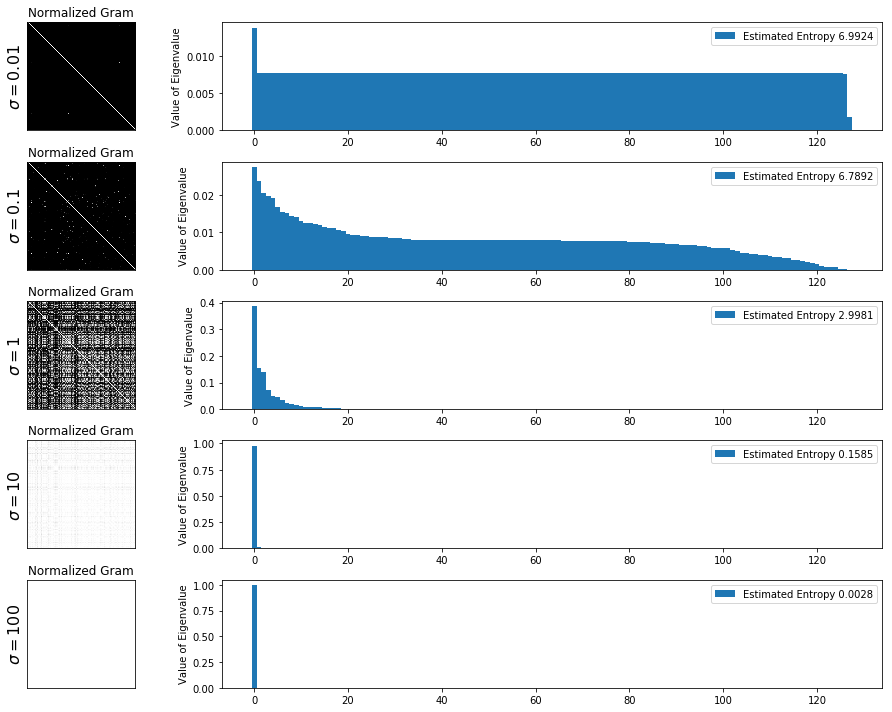

In [5]:
kernel_width_list = [0.01, 0.1, 1, 10, 100]

fig, ax = plt.subplots(
    len(kernel_width_list), 2, 
    figsize=(13, 2*len(kernel_width_list)), 
    gridspec_kw = {'width_ratios':[1, 3]})

for i, kernel_width in enumerate(kernel_width_list):
    # Compute gram matrix
    tf.reset_default_graph()
    estimator = MatrixEstimator(normalize_dimension=False, normalize_scale=False)
    norm_gram_tf = estimator.normalized_gram(z_samples, sigma_x=kernel_width)
    with tf.Session() as sess:
        norm_gram_np = sess.run(norm_gram_tf)

    # Compute eigenvalues and sort in descending order for visualization
    w, _ = np.linalg.eig(norm_gram_np)
    w = np.real(w)
    w = np.clip(w, 0, None)
    w = w / w.sum()
    w = -np.sort(-w)
    # Compute entropy estimation from these eigenvalues
    alpha = 1.01  # Close to one to approximate Shannon
    entropy = np.log2(np.sum(w ** alpha)) / (1.0 - alpha)

    ax[i, 0].set_title('Normalized Gram')
    ax[i, 0].imshow(norm_gram_np, vmin=0, vmax=1/n_samples, cmap='gray')
    ax[i, 0].grid(False)
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_ylabel('$\sigma=%s$' % kernel_width, fontsize=16)

    ax[i, 1].bar(np.arange(w.size), w, 1, label='Estimated Entropy %1.4f' % (entropy))
    ax[i, 1].set_ylabel('Value of Eigenvalue')
    ax[i, 1].legend()

plt.tight_layout()
plt.show()

<h2>Correlated Gaussian test of estimator</h2>

Here we try estimating MI in the Correlated Gaussian game, where we have $N$ samples of two multivariate standard gaussians $X$ and $Y$ of $d$ dimensions with a constant component-wise correlation factor $\rho$. That is, $\mathrm{corr}(X_i, Y_j) = \delta_{ij}\rho$. In this case, the theoretical Shannon MI is known to be 
$$ I(X;Y) = -\frac{d}{2}\log\left(1- \rho^2\right).$$
The goal is to estimate the MI for different values of $N$, $d$ and $\rho$. We additionally added a scaling factor $a$ such that $X\gets aX$ and $Y\gets aY$, which is set to 1.0 by default. The MI should be the same for any $a\not=0$.

In previous works with this estimator, the following rule was used for the kernel width:
$$ \sigma = \gamma N^{-1/(4+d)},$$
where $\gamma$ is an empirical constant.

We found this rule to be problematic, because $\gamma$ was too sensitive to changes in the distribution of $X$ and $Y$ and their dimensionality. Instead, we first normalize the variables $X$ and $Y$, which is achieved by setting ''normalize_scale'' to True. Next, we use:
$$ \sigma = \gamma \sqrt{d} N^{-1/(4+d)},$$
which is achieved by setting ''normalize_dimension'' to True. You can read more on this on our [conference paper](https://arxiv.org/abs/2005.07783). With this new kernel width rule, the value of $\gamma$ is more robust.

You can play with the settings below to see the effect of each parameter. You can recover the behavior of the old rule by setting both normalizations to False. 

Correlated Gaussians Test
Number of samples: 128
Gamma constant: 2.0
Dimension list: [10, 100, 1000]

Computing Shannon MI
Dimension 10
Dimension 100
Dimension 1000

Estimating MI
Dimension 10
Dimension 100
Dimension 1000
Estimation E.T.: 63.1154 [s]


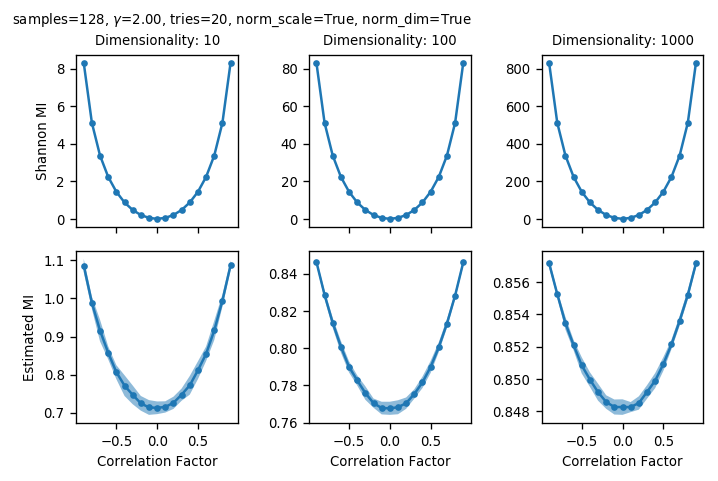

In [7]:
# Settings of experiment
n_samples = 128
gamma_constant = 2.0
dimension_list = [10, 100, 1000]
n_tries = 20
normalize_scale = True
normalize_dimension = True
scale_of_gaussian = 1.0

# ------------ Experiment begins here

print('Correlated Gaussians Test')
print('Number of samples: %s' % n_samples)
print('Gamma constant: %s' % gamma_constant)
print('Dimension list: %s' % dimension_list)
corr_factors = [i * 0.1 for i in range(10)]
corr_neg = [-corr for corr in corr_factors][::-1]
corr_factor_list = corr_neg[0:-1] + corr_factors
n_factors = len(corr_factor_list)

data = CorrelatedGaussians(mode="tensorflow")

# Shannon mutual information theoretical value
print('\nComputing Shannon MI')
shannon_data = {}
for dimension in dimension_list:
    shannon_data[dimension] = np.zeros(n_factors)
    print('Dimension %d' % dimension)
    for i, corr_factor in enumerate(corr_factor_list):
        mut_info = data.get_shannon_mi(dimension, corr_factor)
        shannon_data[dimension][i] = mut_info

# Estimation
print('\nEstimating MI')
start_time = time.time()
estimator_data = {}
estimator = MatrixEstimator(
    gamma=gamma_constant,
    normalize_scale=normalize_scale,
    normalize_dimension=normalize_dimension)
for dimension in dimension_list:
    estimator_data[dimension] = np.zeros((n_factors, n_tries))
    print('Dimension %d' % dimension)
    tf.reset_default_graph()
    corr_factor_ph = tf.placeholder(tf.float32, shape=())
    x_samples, y_samples = data.sample(dimension, corr_factor_ph, n_samples)
    # Scale variables
    x_samples = scale_of_gaussian * x_samples
    y_samples = scale_of_gaussian * y_samples
    mi_estimation_tf = estimator.mutual_information(x_samples, y_samples)
    # Tensorflow session for graph management
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    for i, corr_factor in enumerate(corr_factor_list):
        estimation_tries_list = []
        for j in range(n_tries):
            mi_estimation_np = sess.run(
                mi_estimation_tf, feed_dict={corr_factor_ph: corr_factor})
            estimator_data[dimension][i, j] = mi_estimation_np
end_time = time.time()
print('Estimation E.T.: %1.4f [s]' % (end_time - start_time))

# Plot results
n_dims = len(dimension_list)
fig, axes = plt.subplots(2, n_dims, figsize=(2 * n_dims, 4), sharex=True, dpi=120)
for ax, dim in zip(axes.T, dimension_list):
    # True Shannon MI
    ax[0].set_title("Dimensionality: %d" % dim, fontsize=8)
    ax[0].plot(corr_factor_list, shannon_data[dim], marker='o', markersize=3)
    ax[0].tick_params(labelsize=8)
    # Estimated MI
    estimation_mean = estimator_data[dim].mean(axis=1)
    estimation_std = estimator_data[dim].std(axis=1)
    ax[1].plot(corr_factor_list, estimation_mean, marker='o', markersize=3)
    ax[1].fill_between(
        corr_factor_list,
        estimation_mean - 2 * estimation_std,
        estimation_mean + 2 * estimation_std,
        alpha=0.5)
    ax[1].set_xlabel("Correlation Factor", fontsize=8)
    ax[1].tick_params(labelsize=8)
axes[0, 0].set_ylabel("Shannon MI", fontsize=8)
axes[1, 0].set_ylabel("Estimated MI", fontsize=8)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.text(
    x=0.01, y=0.99, fontsize=8,
    s=r'samples=%d, $\gamma$=%1.2f, tries=%d, norm_scale=%s, norm_dim=%s' % (
        n_samples, gamma_constant, n_tries, normalize_scale, normalize_dimension),
    ha="left", va="top", transform=fig.transFigure)
plt.show()